# Computer vision 2023
- Object detection in satellite images

In [1]:
# imports
from os.path import join
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import random

# Library

In [2]:
def histogram_boxplot(data, feature, figsize=(12, 7), bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    
    f2, (ax_box2, ax_hist2, ax_hist3) = plt.subplots(
        nrows=3,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.2, 0.4, 0.4)},
        figsize=figsize,
    )  # creating the 2 subplots

    # boxplot will be created and a triangle will indicate the mean value of the column
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")
    
    # for histogram
    if bins:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, bins=bins, stat='count')
    else:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, stat='count')

    if bins:
        sns.histplot(data=data, x=feature, kde=True, ax=ax_hist3, bins=bins, stat='density')
    else:
        sns.histplot(data=data, x=feature, kde=True, ax=ax_hist3, stat='density')
    
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    ax_hist3.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist3.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [3]:
def decode_image(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

# Buildings Dataset

**Context**

Building Segmentation from Aerial Imagery is a challenging task. Obstruction from nearby trees, shadows of adjacent buildings, varying texture and color of rooftops, varying shapes and dimensions of buildings are among other challenges that hinder present day models in segmenting sharp building boundaries. High-quality aerial imagery datasets facilitate comparisons of existing methods and lead to increased interest in aerial imagery applications in the machine learning and computer vision communities.

**Content**

- The Massachusetts Buildings Dataset consists of **151** aerial images of the Boston area, with each of the images being 1500 × 1500 pixels for an area of 2.25 square kilometers. 
- Hence, the entire dataset covers roughly 340 square kilometers. 
- The data is split into a training set of 137 images, a test set of 10 images and a validation set of 4 images. 
- The target maps were obtained by rasterizing building footprints obtained from the *OpenStreetMap* project.
- The data was restricted to regions with an average omission noise level of roughly 5% or less.
- The large amount of high quality building footprint data was possible to collect because the City of Boston contributed building footprints for the entire city to the OpenStreetMap project.
- The dataset covers mostly urban and suburban areas and buildings of all sizes, including individual houses and garages, are included in the labels. The datasets make use of imagery released by the state of Massachusetts.
- All imagery is rescaled to a resolution of 1 pixel per square meter. 
- The target maps for the dataset were generated using data from the OpenStreetMap project.
- Target maps for the test and validation portions of the dataset were hand-corrected to make the evaluations more accurate.

**References**
- https://www.kaggle.com/balraj98/massachusetts-buildings-dataset
- https://www.cs.toronto.edu/~vmnih/data/
- https://www.cs.toronto.edu/~vmnih/docs/Mnih_Volodymyr_PhD_Thesis.pdf
- @phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}

In [4]:
BUILDING_BASE_PATH = './building'

In [5]:
metadata = pd.read_csv(join(BUILDING_BASE_PATH, "metadata.csv"))
metadata.tiff_image_path = metadata.tiff_image_path.apply(lambda imgpath: join(BUILDING_BASE_PATH, imgpath))
metadata.tif_label_path = metadata.tif_label_path.apply(lambda imgpath: join(BUILDING_BASE_PATH, imgpath))

In [6]:
metadata.head()

,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,22678915_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,./building/tiff/train/22678915_15.tiff,./building/tiff/train_labels/22678915_15.tif,png/train/22678915_15.png,png/train_labels/22678915_15.png
1,22678930_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,./building/tiff/train/22678930_15.tiff,./building/tiff/train_labels/22678930_15.tif,png/train/22678930_15.png,png/train_labels/22678930_15.png
2,22678945_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,./building/tiff/train/22678945_15.tiff,./building/tiff/train_labels/22678945_15.tif,png/train/22678945_15.png,png/train_labels/22678945_15.png
3,22678960_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,./building/tiff/train/22678960_15.tiff,./building/tiff/train_labels/22678960_15.tif,png/train/22678960_15.png,png/train_labels/22678960_15.png
4,22678975_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,./building/tiff/train/22678975_15.tiff,./building/tiff/train_labels/22678975_15.tif,png/train/22678975_15.png,png/train_labels/22678975_15.png


In [7]:
metadata['split'].value_counts()  # 137 train, 10 test, 4 validation

train    137
test      10
val        4
Name: split, dtype: int64

In [8]:
labels_df = pd.read_csv(join(BUILDING_BASE_PATH, "label_class_dict.csv"))
labels_df.dataframeName = 'label_class_dict.csv'

In [9]:
labels_df

,name,r,g,b
0,background,0,0,0
1,building,255,255,255


In [10]:
labels_df.name.value_counts()

background    1
building      1
Name: name, dtype: int64

In [11]:
clasnames = labels_df['name'].tolist()
class_rgb_values = labels_df[['r','g','b']].values.tolist()
select_class_indices = [clasnames.index(cls.lower()) for cls in clasnames]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
print(select_class_rgb_values)

[[  0   0   0]
 [255 255 255]]


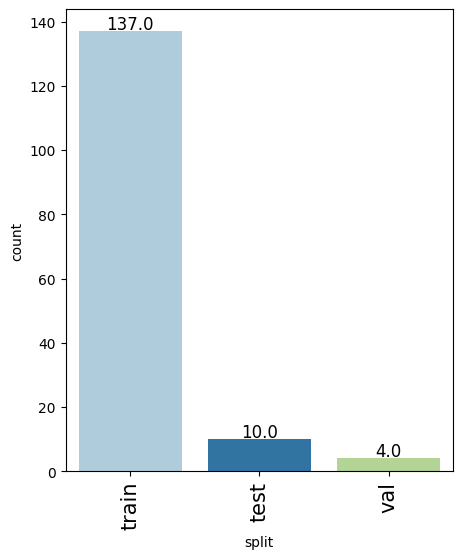

In [12]:
labeled_barplot(metadata, 'split')

- dataset consists of 151 total images, splited in train, test and val.

# Image metadata analysis
- aspect ratio
- size

## TIFF Images

In [13]:
metadata.tiff_image_path.shape

(151,)

In [14]:
image_metadata = []
tiff_image_path = metadata.tiff_image_path.tolist()
for path in tiff_image_path:
    image = decode_image(path)
    info = (
        image.shape[0], image.shape[1], image.shape[2],
    )
    image_metadata.append(info)

In [15]:
image_metadata = pd.DataFrame(image_metadata, columns=['w','h','depth'])

In [16]:
image_metadata.head()

,w,h,depth
0,1500,1500,3
1,1500,1500,3
2,1500,1500,3
3,1500,1500,3
4,1500,1500,3


In [17]:
image_metadata['ratio'] = image_metadata['w'] / image_metadata['h']

- ratio is the aspect ratio by dividing width by height.

In [18]:
image_metadata.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
w,151.0,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0
h,151.0,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0
depth,151.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
ratio,151.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [19]:
image_metadata['ratio'].value_counts()

1.0    151
Name: ratio, dtype: int64

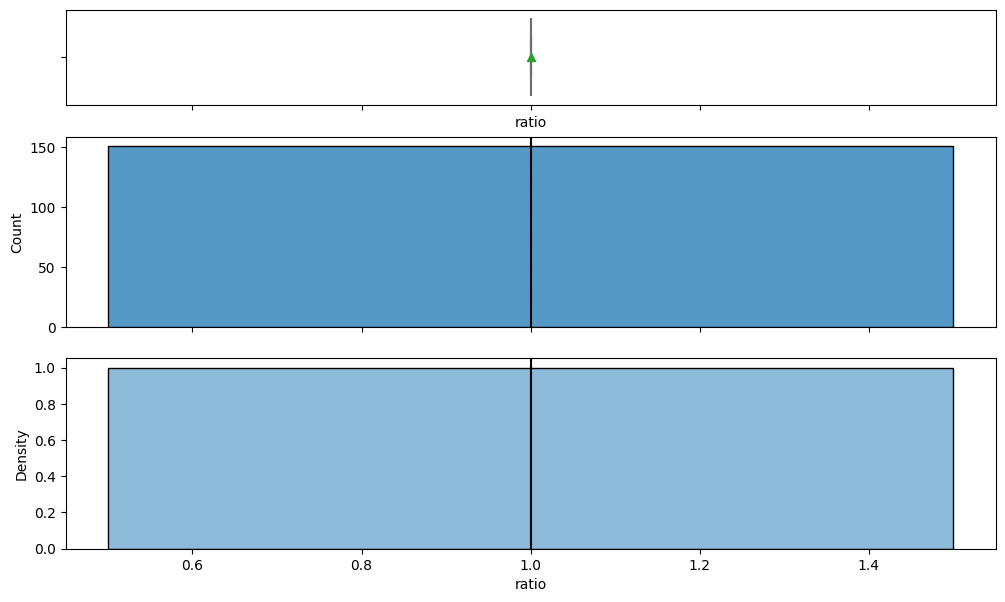

In [20]:
histogram_boxplot(image_metadata, "ratio")

## TIFF Labels

In [21]:
metadata.tif_label_path.shape

(151,)

In [22]:
image_metadata = []
tif_label_path = metadata.tif_label_path.tolist()
for path in tif_label_path:
    image_metadata.append(decode_image(path).shape)

In [23]:
label_metadata = pd.DataFrame(image_metadata, columns=['w','h','depth'])

In [24]:
label_metadata.head()

,w,h,depth
0,1500,1500,3
1,1500,1500,3
2,1500,1500,3
3,1500,1500,3
4,1500,1500,3


In [25]:
label_metadata['ratio'] = label_metadata['w'] / label_metadata['h']

- ratio is the aspect ratio by dividing width by height.

In [26]:
label_metadata.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
w,151.0,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0
h,151.0,1500.0,0.0,1500.0,1500.0,1500.0,1500.0,1500.0
depth,151.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
ratio,151.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [27]:
label_metadata['ratio'].value_counts()

1.0    151
Name: ratio, dtype: int64

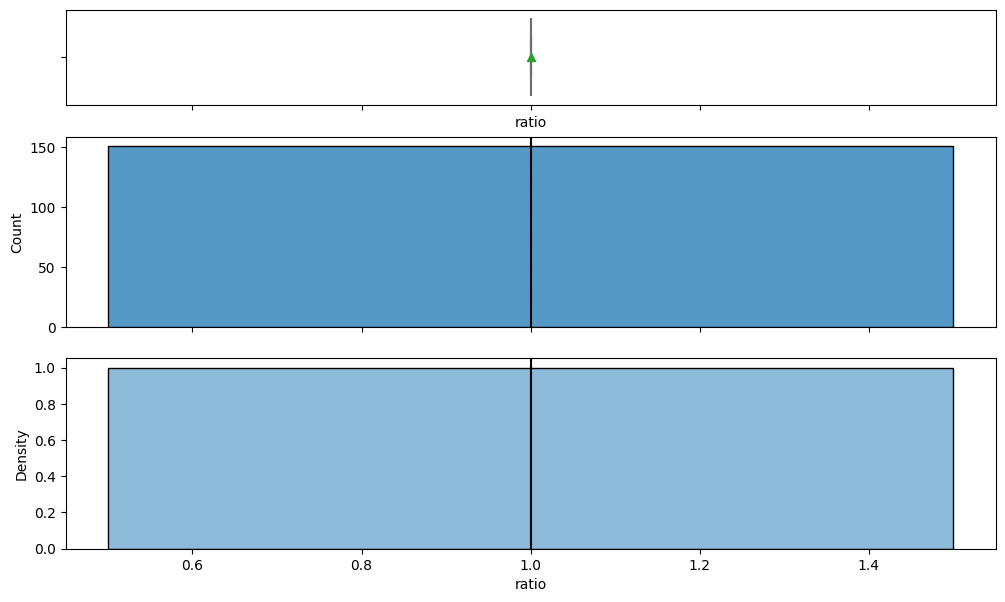

In [28]:
histogram_boxplot(label_metadata, "ratio")

# Image Color Analysis
- find dominant color for each image
- plot dominant colors
- histogram boxplot R, G, B
- compare train, val and test

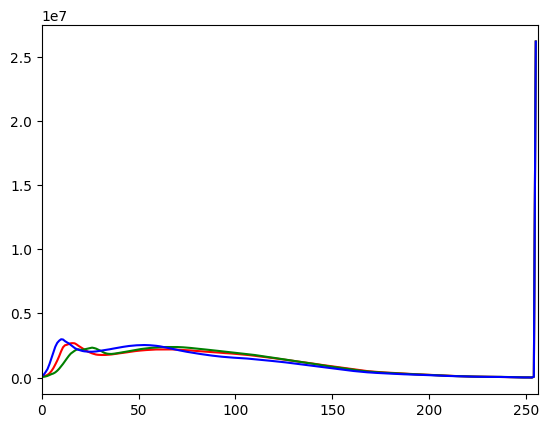

In [91]:
samples = metadata[metadata["split"].isin(['train', 'val'])].tiff_image_path.tolist()

total_hist = [None, None, None]
for sample in samples:
    img = decode_image(sample)
    color = ('r','g','b')
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0, 256]).flatten()
        total_hist[i] = histr if total_hist[i] is None else total_hist[i] + histr

for i, col in enumerate(color):   
    plt.plot(total_hist[i], color = col)
plt.xlim([0, 256])
plt.show()

In [95]:
samples = metadata[metadata["split"].isin(['train', 'val'])].tif_label_path.tolist()

total_hist = [None, None, None]
for sample in samples:
    img = decode_image(sample)
    color = ('r','g','b')
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0, 256]).flatten()
        total_hist[i] = histr if total_hist[i] is None else total_hist[i] + histr

[array([2.7559501e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

# Classification

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [32]:
def displayimages(**images):
    n_images = len(images)
    plt.figure(figsize=(16,8))
    for idx,(name,image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()
    
def onehotencode(label,labelvals):
    semanticmap = []
    for color in labelvals:
        equality = np.equal(label,color)
        classmap = np.all(equality,axis=-1)
        semanticmap.append(classmap)
    semanticmap = np.stack(semanticmap, axis=-1)
    return semanticmap

def reverseonehot(image):
    rev = np.argmax(image,axis=-1)
    return rev

def color_code_segment(image,labelvals):
    colorcodes = np.array(labelvals)
    ccs = colorcodes[image.astype(int)]
    return ccs

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(album.Lambda(image=preprocessing_fn))
    transform.append(album.Lambda(image=convert_to_tensor,mask=convert_to_tensor))
    return album.Compose(transform)

In [33]:
class DatasetCreation(torch.utils.data.Dataset):
    def __init__(self, metadata, class_rgb_vals=None, augment=None, preprocess=None):
        self.class_rgb_vals = class_rgb_vals
        self.metadata = metadata
        self.augment = augment
        self.preprocess = preprocess
        self.imagespath = metadata.tiff_image_path.tolist()
        self.maskspath = metadata.tif_label_path.tolist()

        self.imagespath = [join(BUILDING_BASE_PATH, p) for p in self.imagespath]
        self.maskspath = [join(BUILDING_BASE_PATH, p) for p in self.maskspath]
        
    def __len__(self):
        return self.metadata.shape[0]
        
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.imagespath[i]),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.maskspath[i]),cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))
        mask = cv2.resize(mask, (512,512))
        mask = onehotencode(mask, self.class_rgb_vals).astype("float")
        if self.preprocess:
            sample = self.preprocess(image=image, mask=mask)
            image,mask = sample['image'], sample['mask']
        return image, mask